In [1]:
import numpy as np
import cv2
import os
from skimage.feature import local_binary_pattern
import copy
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from collections import defaultdict
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import validation_curve
from skimage.feature import hog
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib 
import time

In [2]:
def scrapeFile(file):
    filepath = file
    X={}
    Y={}
    with open(filepath) as fp:  
        line = fp.readline()      
        while line:
            l=line.strip()
            a=l.split(",")
            temp=[]
            for p in a[1:]:
                temp.append(float(p))
            X[int(a[0])]=temp
            Y[int(a[0])]=np.argmax(temp)
            line = fp.readline()
    return X,Y

In [3]:
def hog_f(image):
    hist = hog(image,orientations=9,pixels_per_cell=(16,16),cells_per_block=(3,3))
    temp=[]
    for j in range(len(hist)):
        temp.append(hist[j])
    return temp

In [4]:
def lbp_f(image):
    lbp = local_binary_pattern(image,8,1,'uniform') 
    lbp_hist = np.histogram(lbp, bins=np.arange(257), density=True)[0]
    return list(lbp_hist)

In [5]:
def color_lbp_f(image):
    R=image[:,:,2]
    G=image[:,:,1]
    B=image[:,:,0]    
    lbp_r = local_binary_pattern(R,8,1,'uniform')
    lbp_g = local_binary_pattern(G,8,1,'uniform')
    lbp_b = local_binary_pattern(B,8,1,'uniform') 
    l_r = np.histogram(lbp_r, bins=np.arange(257), density=True)[0]
    l_g = np.histogram(lbp_g, bins=np.arange(257), density=True)[0]
    l_b = np.histogram(lbp_b, bins=np.arange(257), density=True)[0] 
    return list(l_b)+list(l_g)+list(l_r)

In [6]:
def color_hog_f(image):
    R=image[:,:,2]
    G=image[:,:,1]
    B=image[:,:,0]
    hist_R =hog(R,orientations=9,pixels_per_cell=(16,16),cells_per_block=(3,3))
    hist_G=hog(G,orientations=9,pixels_per_cell=(16,16),cells_per_block=(3,3))
    hist_B=hog(B,orientations=9,pixels_per_cell=(16,16),cells_per_block=(3,3))
    temp1=[]
    temp2=[]
    temp3=[]
    for j in range(len(hist_R)):
        temp1.append(hist_R[j])
        temp2.append(hist_G[j])
        temp3.append(hist_B[j])
    return temp3+temp2+temp1

In [7]:
###########################PCA############################
def pca_feature(X):
    pca=PCA(n_components=0.99)
    pca.fit(X)
    newX=(pca.transform(X))
    return list(newX)

In [8]:
###################MOMENTS FEATURE#########################
def image_moment_feature(image):
    ret,thresh = cv2.threshold(image,80,255,0)
    im2,contours,hierarchy = cv2.findContours(thresh, 1, 2)
    #print(np.shape(contours))
    cnt = contours[0]
    M = cv2.moments(cnt)
    f=[]
    for k in M:
        f.append(M[k])
    return list(f)

In [9]:
def feature_extraction(img,gray):
    featureset=[]
    featureset+=lbp_f(gray)
    #featureset+=image_moment_feature(img)
    #featureset+=hog_f(gray)
    return featureset

In [10]:
def qwise_prediction(prediction):
    prediction=np.array(prediction)
    prediction=prediction.T
    Q1_pred=normalize(prediction[:,0:3])
    Q2_pred=normalize(prediction[:, 3:5])
    Q3_pred=normalize(prediction[:, 5:7])
    Q4_pred=normalize(prediction[:, 7:9])
    Q5_pred=normalize(prediction[:, 9:13])
    Q6_pred=normalize(prediction[:, 13:15])
    Q7_pred=normalize(prediction[:, 15:18])
    Q8_pred=normalize(prediction[:, 18:25])
    Q9_pred=normalize(prediction[:, 25:28])
    Q10_pred=normalize(prediction[:, 28:31])
    Q11_pred=normalize(prediction[:, 31:37])
    result=[Q1_pred,Q2_pred,Q3_pred,Q4_pred,Q5_pred,Q6_pred,Q7_pred,Q8_pred,Q9_pred,Q10_pred,Q11_pred]
    return result


In [11]:
def rmse_calculation(y_true,prediction):
    mse=[]
    for i in range(11):
        y=np.array(y_true[i].iloc[7000:10000])
        mse.append(mean_squared_error(y,prediction[i]))
    return mse

In [12]:
def plotGraph(x,y):
    plt.bar(x,y)
    plt.xlabel("Question")
    plt.ylabel("RMSE")
    plt.show()

In [13]:
def normalize(zl):
    e_x = np.exp(zl - np.max(zl))
    gz=e_x / e_x.sum()
    y=gz/gz.sum(axis=1)[:,None]
    return y

In [14]:
df=pd.read_csv("training_solutions_rev1.csv")
y=["GalaxyID"]
for x in df.columns[1:]:
    y.append(x[-1])
df.columns=y

In [15]:
#Separation of questions
Q1=df.iloc[:, 1:4]
q1=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q2=df.iloc[:, 4:6]
q2=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q3=df.iloc[:, 6:8]
q3=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q4=df.iloc[:, 8:10]
q4=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q5=df.iloc[:, 10:14]
q5=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q6=df.iloc[:, 14:16]
q6=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q7=df.iloc[:, 16:19]
q7=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q8=df.iloc[:, 19:26]
q8=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q9=df.iloc[:, 26:29]
q9=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q10=df.iloc[:, 29:32]
q10=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q11=df.iloc[:, 32:38]
q11=pd.concat([df["GalaxyID"].to_frame(),Q1],axis=1)
Q_idx=[Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11]

In [15]:
train_ids=np.array(q1["GalaxyID"])[0:7000]
test_ids=np.array(q1["GalaxyID"])[7000:10000]

In [16]:
X,Y=scrapeFile("training_solutions")


In [17]:
train_features=[]
datapath="images_training_rev1/"
train_features=[]
for i in range(7000):
    path="images_training_rev1/"+str(train_ids[i])+".jpg"
    image=cv2.imread(path)
    gray=cv2.imread(path,0)
    crop1 = image[108:108+207, 108:108+207]
    crop2 = gray[108:108+207, 108:108+207]
    feature=feature_extraction(crop1,crop2)
    train_features.append(feature)
    if i%1000==0:
        print(i,"..Done")

0 ..Done
1000 ..Done
2000 ..Done
3000 ..Done
4000 ..Done
5000 ..Done
6000 ..Done


In [23]:
len(train_features[0])

256

In [18]:
test_features=[]
for i in range(3000):
    path="images_training_rev1/"+str(test_ids[i])+".jpg"
    image=cv2.imread(path)
    gray=cv2.imread(path,0)
    crop1 = image[108:108+207, 108:108+207]
    crop2 = gray[108:108+207, 108:108+207]
    feature=feature_extraction(crop1,crop2)
    test_features.append(feature)
    if i%1000==0:
        print(i,"..Done")

0 ..Done
1000 ..Done
2000 ..Done


In [19]:
datapath="images_training_rev1/"
files_list = sorted(os.listdir(datapath))
dataset=[]
datalabel=[]
category=defaultdict(list)
featureset=[]
idx=0
for file in files_list[0:10000]:
    id1=int(file[:-4])
    datalabel.append(X[id1])
    for i in range(37):
        category[i].append(X[id1][i])
    idx+=1
    if idx%1000==0:
        print(idx,"..Done")
    


1000 ..Done
2000 ..Done
3000 ..Done
4000 ..Done
5000 ..Done
6000 ..Done
7000 ..Done
8000 ..Done
9000 ..Done
10000 ..Done


In [20]:
prediction_LR=[]
for i in range(37):
    start=time.time()
    clf = LinearRegression().fit(train_features,np.array(df.iloc[:,i+1])[0:7000] )
    file_name="C"+str(i+1)+"_linear.pkl"
    joblib.dump(clf, file_name) 
    y_predict=clf.predict(test_features)
    end=time.time()
    prediction_LR.append(y_predict)  
    print(i,"..Done","Time=",end-start)
    #rmse=mean_squared_error(y_true, y_predict)

0 ..Done Time= 0.6241614818572998
1 ..Done Time= 0.47359752655029297
2 ..Done Time= 0.4698827266693115
3 ..Done Time= 0.5438206195831299
4 ..Done Time= 0.5468401908874512
5 ..Done Time= 0.47074198722839355
6 ..Done Time= 0.4702723026275635
7 ..Done Time= 0.46802496910095215
8 ..Done Time= 0.4688847064971924
9 ..Done Time= 0.6983914375305176
10 ..Done Time= 0.5138278007507324
11 ..Done Time= 0.5540218353271484
12 ..Done Time= 0.4624781608581543
13 ..Done Time= 0.5500118732452393
14 ..Done Time= 0.4777219295501709
15 ..Done Time= 0.4914357662200928
16 ..Done Time= 0.4831843376159668
17 ..Done Time= 0.4735734462738037
18 ..Done Time= 0.4762134552001953
19 ..Done Time= 0.481858491897583
20 ..Done Time= 0.5733852386474609
21 ..Done Time= 0.563129186630249
22 ..Done Time= 0.44040894508361816
23 ..Done Time= 0.4455246925354004
24 ..Done Time= 0.4902968406677246
25 ..Done Time= 0.47946667671203613
26 ..Done Time= 0.4442024230957031
27 ..Done Time= 0.45574951171875
28 ..Done Time= 0.44456481933

In [21]:
prediction_LoR=[]
for i in range(37):
    start=time.time()
    clf = Lasso().fit(train_features,np.array(df.iloc[:,i+1])[0:7000] )
    file_name="C"+str(i+1)+"_lasso"+".pkl"
    joblib.dump(clf, file_name) 
    y_predict=clf.predict(test_features)
    end=time.time()
    prediction_LoR.append(y_predict)  
    print(i,"..Done","Time=",end-start)
    #rmse=mean_squared_error(y_true, y_predict)

0 ..Done Time= 0.3842930793762207
1 ..Done Time= 0.33468127250671387
2 ..Done Time= 0.32672929763793945
3 ..Done Time= 0.3365809917449951
4 ..Done Time= 0.40340709686279297
5 ..Done Time= 0.3275625705718994
6 ..Done Time= 0.326552152633667
7 ..Done Time= 0.3322911262512207
8 ..Done Time= 0.3291447162628174
9 ..Done Time= 0.3288094997406006
10 ..Done Time= 0.3263850212097168
11 ..Done Time= 0.33205103874206543
12 ..Done Time= 0.3243703842163086
13 ..Done Time= 0.330352783203125
14 ..Done Time= 0.33321332931518555
15 ..Done Time= 0.3304629325866699
16 ..Done Time= 0.3270082473754883
17 ..Done Time= 0.33354711532592773
18 ..Done Time= 0.32762956619262695
19 ..Done Time= 0.33464837074279785
20 ..Done Time= 0.32938647270202637
21 ..Done Time= 0.42002201080322266
22 ..Done Time= 0.347916841506958
23 ..Done Time= 0.33408522605895996
24 ..Done Time= 0.3248865604400635
25 ..Done Time= 0.32566046714782715
26 ..Done Time= 0.33245372772216797
27 ..Done Time= 0.32498908042907715
28 ..Done Time= 0.3

In [22]:
prediction_RR=[]
for i in range(37):
    start=time.time()
    clf = Ridge().fit(train_features,np.array(df.iloc[:,i+1])[0:7000] )
    file_name="C"+str(i+1)+"_ridge"+".pkl"
    joblib.dump(clf, file_name) 
    y_predict=clf.predict(test_features)
    end=time.time()
    prediction_RR.append(y_predict)  
    print(i,"..Done","Time=",end-start)
    #rmse=mean_squared_error(y_true, y_predict)

0 ..Done Time= 0.36861681938171387
1 ..Done Time= 0.36380648612976074
2 ..Done Time= 0.368915319442749
3 ..Done Time= 0.36637139320373535
4 ..Done Time= 0.36777615547180176
5 ..Done Time= 0.37180376052856445
6 ..Done Time= 0.3763871192932129
7 ..Done Time= 0.37778711318969727
8 ..Done Time= 0.38069701194763184
9 ..Done Time= 0.36947059631347656
10 ..Done Time= 0.371814489364624
11 ..Done Time= 0.3695998191833496
12 ..Done Time= 0.3595998287200928
13 ..Done Time= 0.3629188537597656
14 ..Done Time= 0.36406421661376953
15 ..Done Time= 0.33461451530456543
16 ..Done Time= 0.3402831554412842
17 ..Done Time= 0.3637962341308594
18 ..Done Time= 0.3371238708496094
19 ..Done Time= 0.33535051345825195
20 ..Done Time= 0.3406105041503906
21 ..Done Time= 0.3417038917541504
22 ..Done Time= 0.3587765693664551
23 ..Done Time= 0.3605160713195801
24 ..Done Time= 0.3643651008605957
25 ..Done Time= 0.3613321781158447
26 ..Done Time= 0.3579556941986084
27 ..Done Time= 0.3644711971282959
28 ..Done Time= 0.352

In [40]:
qwise_pred_LR=qwise_prediction(prediction_LR)
qwise_mse_LR=rmse_calculation(Q_idx,qwise_pred_LR)
qwise_pred_LoR=qwise_prediction(prediction_LoR)
qwise_mse_LoR=rmse_calculation(Q_idx,qwise_pred_LoR)
qwise_pred_RR=qwise_prediction(prediction_RR)
qwise_mse_RR=rmse_calculation(Q_idx,qwise_pred_RR)

In [41]:
print(qwise_mse_LR)
print(qwise_mse_LoR)
print(qwise_mse_RR)

[0.07196763179096223, 0.1248387048525248, 0.128631667306605, 0.1357577621336917, 0.042593155973258474, 0.06819268814385024, 0.07507782316242746, 0.018042617159707886, 0.09914381559068676, 0.0854349443800745, 0.027960121141596978]
[0.07879490190612377, 0.1264636737479915, 0.12883303199479917, 0.13728021615288194, 0.042909335581535354, 0.06872239312948386, 0.0764688760838494, 0.018083135932463072, 0.0993138244747339, 0.0854839350029745, 0.028016165016722838]
[0.07359150825262811, 0.12591527552246098, 0.12871988631964845, 0.13601939589485437, 0.042688396228247265, 0.06842257661904566, 0.07555021226393094, 0.01805424096354191, 0.09922606706879357, 0.08544783789696835, 0.027975909989862286]


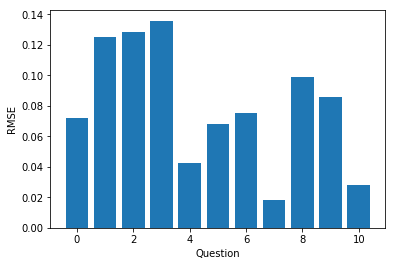

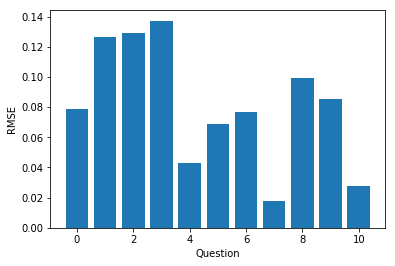

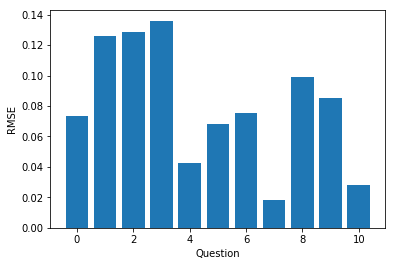

In [42]:
q=np.arange(11)
plotGraph(q,qwise_mse_LR)
plotGraph(q,qwise_mse_LoR)
plotGraph(q,qwise_mse_RR)

In [20]:
qwise_mse_LR=[0.07879490190612377, 0.1264636737479915, 0.12883303199479917, 0.13728021615288194, 0.042909335581535354, 0.06872239312948386, 0.0764688760838494, 0.018083135932463072, 0.0993138244747339, 0.0854839350029745, 0.028016165016722838]
qwise_mse_LoR=[0.07879490190612377, 0.1264636737479915, 0.12883303199479917, 0.13728021615288194, 0.042909335581535354, 0.06872239312948386, 0.0764688760838494, 0.018083135932463072, 0.0993138244747339, 0.0854839350029745, 0.028016165016722838]
qwise_mse_RR=[0.07359150825262811, 0.12591527552246098, 0.12871988631964845, 0.13601939589485437, 0.042688396228247265, 0.06842257661904566, 0.07555021226393094, 0.01805424096354191, 0.09922606706879357, 0.08544783789696835, 0.027975909989862286]


In [22]:
cnn_q1=np.array(pd.read_csv("Q1_Output.csv").drop("Id",axis=1))
cnn_q2=np.array(pd.read_csv("Q2_Output.csv").drop("Id",axis=1))
cnn_q3=np.array(pd.read_csv("Q3_Output.csv").drop("Id",axis=1))
cnn_q4=np.array(pd.read_csv("Q4_Output.csv").drop("Id",axis=1))
cnn_q5=np.array(pd.read_csv("Q5_Output.csv").drop("Id",axis=1))
cnn_q6=np.array(pd.read_csv("Q6_Output.csv").drop("Id",axis=1))
cnn_q7=np.array(pd.read_csv("Q7_Output.csv").drop("Id",axis=1))
cnn_q8=np.array(pd.read_csv("Q8_Output.csv").drop("Id",axis=1))
cnn_q9=np.array(pd.read_csv("Q9_Output.csv").drop("Id",axis=1))
cnn_q10=np.array(pd.read_csv("Q10_Output.csv").drop("Id",axis=1))
cnn_q11=np.array(pd.read_csv("Q11_Output.csv").drop("Id",axis=1))
cnn_pred=[cnn_q1,cnn_q2,cnn_q3,cnn_q4,cnn_q5,cnn_q6,cnn_q7,cnn_q8,cnn_q9,cnn_q10,cnn_q11]

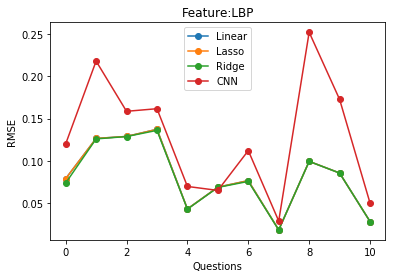

In [23]:
qwise_mse_cnn=rmse_calculation(Q_idx,cnn_pred)
q=np.arange(11)
plt.plot(q,qwise_mse_LR,marker='o')
plt.plot(q,qwise_mse_LoR,marker='o')
plt.plot(q,qwise_mse_RR,marker='o')
plt.plot(q,qwise_mse_cnn,marker='o')
plt.xlabel("Questions")
plt.ylabel("RMSE")
plt.legend(["Linear","Lasso","Ridge","CNN"])
plt.title("Feature:LBP")
plt.show()